In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# --- Funktion zum Laden von Features ---
def load_gtsrb_precomputed_features(data_dir, feature_folder_name):
    """
    Lädt vorberechnete Features (HOG, Haar, HueHist) und zugehörige Labels aus dem GTSRB-Datensatz.
    Die Features werden aus den .txt-Dateien geladen.

    Args:
        data_dir (str): Pfad zum GTSRB-Verzeichnis (z.B. 'data/GTSRB').
        feature_folder_name (str): Der Name des Feature-Ordners ('HOG', 'Haar', 'HueHist').

    Returns:
        tuple: Ein Tupel mit vier NumPy-Arrays:
            - train_features (np.array): Features der Trainingsbilder.
            - train_labels (np.array): Labels der Trainingsbilder.
            - test_features (np.array): Features der Testbilder.
            - test_labels (np.array): Labels der Testbilder.
    """
    
    all_train_features = []
    all_train_labels = []
    all_test_features = []
    all_test_labels = []

    train_base_dir = os.path.join(data_dir, 'Final_Training')
    train_images_csv_dir = os.path.join(train_base_dir, 'Images')

    # Bestimmung des Basisverzeichnisses für Feature-Dateien im Training
    if feature_folder_name == 'HOG':
        train_feature_files_dir = os.path.join(train_base_dir, 'HOG', 'HOG_01')
    elif feature_folder_name in ['Haar', 'HueHist']:
        train_feature_files_dir = os.path.join(train_base_dir, feature_folder_name) 
    else:
        raise ValueError(f"Unbekannter Feature-Typ: '{feature_folder_name}'. Erwartet 'HOG', 'Haar' oder 'HueHist'.")

    print(f"Lade {feature_folder_name}-Features für Trainingsdaten (erwarteter Basis-Pfad: {train_feature_files_dir})...")
    
    for class_id_str in sorted(os.listdir(train_images_csv_dir)):
        class_csv_path = os.path.join(train_images_csv_dir, class_id_str, f'GT-{class_id_str}.csv')
        if not os.path.exists(class_csv_path):
            continue 

        try:
            df = pd.read_csv(class_csv_path, sep=';')
        except Exception as e:
            print(f"Warnung: Trainings-CSV '{class_csv_path}' konnte nicht geladen werden: {e}. Klasse {class_id_str} übersprungen.")
            continue
        
        for _, row in df.iterrows():
            img_filename = row['Filename'] 
            feature_filename_base = img_filename.replace('.txt')
            feature_filepath = os.path.join(train_feature_files_dir, class_id_str, feature_filename_base)

            try:
                features = np.loadtxt(feature_filepath)
                all_train_features.append(features)
                all_train_labels.append(row['ClassId'])
            except FileNotFoundError:
                # print(f"Warnung: {feature_folder_name}-Feature-Datei '{feature_filepath}' nicht gefunden. Bild übersprungen.")
                pass 
            #edge cases
            except Exception as e:
                print(f"Fehler beim Laden von {feature_folder_name}-Features '{feature_filepath}': {e}. Bild übersprungen.")

    test_base_dir = os.path.join(data_dir, 'Final_Test')
    test_csv_path = os.path.join(test_base_dir, 'Images', 'GT-final_test.csv') 

    # Bestimmung des Basisverzeichnisses für Feature-Dateien im Test
    if feature_folder_name == 'HOG':
        test_feature_files_dir = os.path.join(test_base_dir, 'HOG', 'HOG_01')
    elif feature_folder_name in ['Haar', 'HueHist']:
        test_feature_files_dir = os.path.join(test_base_dir, feature_folder_name) 
    else: 
        raise ValueError(f"Unbekannter Feature-Typ: '{feature_folder_name}'.")

    print(f"Lade {feature_folder_name}-Features für Testdaten (erwarteter Basis-Pfad: {test_feature_files_dir})...")
    try:
        test_df = pd.read_csv(test_csv_path, sep=';')
    except Exception as e:
        print(f"Warnung: Test-CSV '{test_csv_path}' konnte nicht geladen werden: {e}. Testdaten nicht geladen.")
        return np.array(all_train_features), np.array(all_train_labels), np.array([]), np.array([]) 
    
    for _, row in test_df.iterrows():
        img_filename = row['Filename'] # z.B. 00000.ppm
        feature_filename_base = img_filename.replace('.ppm', '.txt')
        
        feature_filepath = os.path.join(test_feature_files_dir, feature_filename_base)

        try:
            features = np.loadtxt(feature_filepath)
            all_test_features.append(features)
            all_test_labels.append(row['ClassId'])
        except FileNotFoundError:
            # print(f"Warnung: {feature_folder_name}-Feature-Datei '{feature_filepath}' nicht gefunden. Testbild übersprungen.")
            pass
        # edge cases
        except Exception as e:
            print(f"Fehler beim Laden von {feature_folder_name}-Features '{feature_filepath}': {e}. Testbild übersprungen.")

    return (np.array(all_train_features), np.array(all_train_labels),
            np.array(all_test_features), np.array(all_test_labels))

# --- Laden aller Feature-Typen ---
data_directory = 'data/GTSRB' 

print(f"Starte Ladevorgang der Features aus: {data_directory}")

# Laden der HOG-Features
train_hog_features, train_labels_hog, test_hog_features, test_labels_hog = load_gtsrb_precomputed_features(data_directory, 'HOG')
print(f"\nLoaded HOG: Train Shape {train_hog_features.shape}, Test Shape {test_hog_features.shape}")
print(f"HOG Train Labels Shape: {train_labels_hog.shape}, Test Labels Shape: {test_labels_hog.shape}")
if train_hog_features.shape[0] > 0 and train_hog_features.shape[1] != 1568:
    print(f"WARNUNG: HOG: Erwartete 1568 Features, aber es wurden {train_hog_features.shape[1]} Features gefunden.")

# Laden der Haar-Features
train_haar_features, train_labels_haar, test_haar_features, test_haar_labels = load_gtsrb_precomputed_features(data_directory, 'Haar')
print(f"\nLoaded Haar: Train Shape {train_haar_features.shape}, Test Shape {test_haar_features.shape}")
print(f"Haar Train Labels Shape: {train_labels_haar.shape}, Test Labels Shape: {test_haar_labels.shape}")
if train_haar_features.shape[0] > 0 and train_haar_features.shape[1] > 0:
    print(f"Haar-Features Dimensionalität: {train_haar_features.shape[1]}")


# Laden der HueHist-Features
train_huehist_features, train_labels_huehist, test_huehist_features, test_huehist_labels = load_gtsrb_precomputed_features(data_directory, 'HueHist')
print(f"\nLoaded HueHist: Train Shape {train_huehist_features.shape}, Test Shape {test_huehist_features.shape}")
print(f"HueHist Train Labels Shape: {train_labels_huehist.shape}, Test Labels Shape: {test_huehist_labels.shape}")
if train_huehist_features.shape[0] > 0 and train_huehist_features.shape[1] > 0:
    print(f"HueHist-Features Dimensionalität: {train_huehist_features.shape[1]}")



Starte Ladevorgang der Features aus: data/GTSRB
Lade HOG-Features für Trainingsdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Training/HOG/HOG_01)...
Lade HOG-Features für Testdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Test/HOG/HOG_01)...

Loaded HOG: Train Shape (39209, 1568), Test Shape (12630, 1568)
HOG Train Labels Shape: (39209,), Test Labels Shape: (12630,)
Lade Haar-Features für Trainingsdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Training/Haar)...
Lade Haar-Features für Testdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Test/Haar)...

Loaded Haar: Train Shape (39209, 11584), Test Shape (12630, 11584)
Haar Train Labels Shape: (39209,), Test Labels Shape: (12630,)
Haar-Features Dimensionalität: 11584
Lade HueHist-Features für Trainingsdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Training/HueHist)...
Lade HueHist-Features für Testdaten (erwarteter Basis-Pfad: data/GTSRB/Final_Test/HueHist)...

Loaded HueHist: Train Shape (39209, 256), Test Shape (12630, 256)
HueHist Train

In [ ]:

train_labels = train_labels_hog
test_labels = test_labels_hog

# --- Features kombinieren ---

# Verketten der Feature-Arrays horizontal (axis=1).


#all features
# if (train_hog_features.shape[0] == train_haar_features.shape[0] == train_huehist_features.shape[0] and
#     test_hog_features.shape[0] == test_haar_features.shape[0] == test_huehist_features.shape[0]):

#     train_combined_features = np.concatenate((train_hog_features, train_haar_features, train_huehist_features), axis=1)
#     test_combined_features = np.concatenate((test_hog_features, test_haar_features, test_huehist_features), axis=1)

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])
    
# No haar features
# if (train_hog_features.shape[0] == train_huehist_features.shape[0] and
#     test_hog_features.shape[0]  == test_huehist_features.shape[0]):

#     train_combined_features = np.concatenate((train_hog_features, train_huehist_features), axis=1)
#     test_combined_features = np.concatenate((test_hog_features, test_huehist_features), axis=1)

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])


#no HueHist features

# if (train_hog_features.shape[0] == train_haar_features.shape[0] and
#     test_hog_features.shape[0] == test_haar_features.shape[0]):

#     train_combined_features = np.concatenate((train_hog_features, train_haar_features), axis=1)
#     test_combined_features = np.concatenate((test_hog_features, test_haar_features), axis=1)

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])

#no HOG features

# if (train_haar_features.shape[0] == train_huehist_features.shape[0] and
#     test_haar_features.shape[0] == test_huehist_features.shape[0]):

#     train_combined_features = np.concatenate((train_haar_features, train_huehist_features), axis=1)
#     test_combined_features = np.concatenate((test_haar_features, test_huehist_features), axis=1)

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])
    
#haar only
    
# if (train_haar_features.shape[0] and test_haar_features.shape[0]):

#     train_combined_features = train_haar_features
#     test_combined_features = test_haar_features

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])

#huehist only
    
# if (train_huehist_features.shape[0] and test_huehist_features.shape[0]):

#     train_combined_features = train_huehist_features
#     test_combined_features = test_huehist_features

#     print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
# else:
#     print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
#     train_combined_features = np.array([])
#     test_combined_features = np.array([])

#hog only
    
if train_hog_features.shape[0] and test_hog_features.shape[0]:

    train_combined_features = train_hog_features
    test_combined_features = test_hog_features

    print(f"\nKombinierte Features: Train Shape {train_combined_features.shape}, Test Shape {test_combined_features.shape}")
else:
    print("\nFEHLER: Anzahl der Samples der geladenen Features stimmt nicht überein! Überprüfe die Ladevorgänge.")
    train_combined_features = np.array([])
    test_combined_features = np.array([])


# --- train-val-test split  ---
if train_combined_features.shape[0] > 0:
    X_train_rf_full = train_combined_features
    y_train_rf_full = train_labels 

    X_test_rf = test_combined_features
    y_test_rf = test_labels 

    X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
        X_train_rf_full, y_train_rf_full,
        test_size=0.15, 
        random_state=42,
        stratify=y_train_rf_full # Klassenverteilung soll erhalten werden
    )

    print(f"\nDaten für Random Forest vorbereitet (kombinierte Features):")
    print(f"Trainingsdaten: X_train_rf.shape={X_train_rf.shape}, y_train_rf.shape={y_train_rf.shape}")
    print(f"Validierungsdaten: X_val_rf.shape={X_val_rf.shape}, y_val_rf.shape={y_val_rf.shape}")
    print(f"Testdaten (final): X_test_rf.shape={X_test_rf.shape}, y_test_rf.shape={y_test_rf.shape}")

    # --- Random Forest Modell initialisieren und trainieren ---
    rf_model = RandomForestClassifier(
        n_estimators=200,      
        random_state=42,
        n_jobs=-1, 
        verbose=1             
    )

    print("\nStarte Training des Random Forest Modells mit kombinierten Features...")
    rf_model.fit(X_train_rf, y_train_rf)
    print("Training abgeschlossen.")

    # --- Modell evaluieren ---

    # Evaluation auf dem Validierungsset
    y_val_pred_rf = rf_model.predict(X_val_rf)
    val_accuracy_rf = accuracy_score(y_val_rf, y_val_pred_rf)
    print(f"\nValidierungs-Genauigkeit (Random Forest mit kombinierten Features): {val_accuracy_rf:.4f}")
    print("Validierungs-Klassifikationsbericht:")
    print(classification_report(y_val_rf, y_val_pred_rf, zero_division=0))


else:
    print("Kann Random Forest nicht trainieren, da kombinierte Features nicht korrekt geladen/generiert wurden.")


Kombinierte Features: Train Shape (39209, 1568), Test Shape (12630, 1568)

Daten für Random Forest vorbereitet (kombinierte Features):
Trainingsdaten: X_train_rf.shape=(33327, 1568), y_train_rf.shape=(33327,)
Validierungsdaten: X_val_rf.shape=(5882, 1568), y_val_rf.shape=(5882,)
Testdaten (final): X_test_rf.shape=(12630, 1568), y_test_rf.shape=(12630,)

Starte Training des Random Forest Modells mit kombinierten Features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Training abgeschlossen.

Validierungs-Genauigkeit (Random Forest mit kombinierten Features): 0.9789
Validierungs-Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        31
           1       0.97      0.93      0.95       333
           2       0.94      0.96      0.95       338
           3       0.98      0.94      0.96       212
           4       0.99      0.96      0.97       297
           5       0.89      0.92      0.90       279
           6       1.00      1.00      1.00        63
           7       0.96      0.99      0.97       216
           8       0.94      0.97      0.95       212
           9       0.98      1.00      0.99       221
          10       0.99      1.00      1.00       302
          11       0.98      0.99      0.99       198
          12       1.00      1.00      1.00       315
          13       0.99      1.00      1.00       324
          14       1.00      0.98      0.99       11

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In [41]:
# Evaluation auf dem finalen Testset
y_test_pred_rf = rf_model.predict(X_test_rf)
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
print(f"\nTest-Genauigkeit (Random Forest mit kombinierten Features): {test_accuracy_rf:.4f}")
print("Test-Klassifikationsbericht:")
print(classification_report(y_test_rf, y_test_pred_rf, zero_division=0))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s



Test-Genauigkeit (Random Forest mit kombinierten Features): 0.9411
Test-Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        60
           1       0.96      0.88      0.92       720
           2       0.86      0.98      0.91       750
           3       0.97      0.83      0.89       450
           4       0.92      0.96      0.94       660
           5       0.85      0.91      0.88       630
           6       0.86      0.78      0.82       150
           7       0.96      0.94      0.95       450
           8       0.92      0.90      0.91       450
           9       0.94      1.00      0.97       480
          10       0.98      0.99      0.99       660
          11       0.87      0.95      0.91       420
          12       0.99      1.00      0.99       690
          13       0.99      1.00      1.00       720
          14       0.99      0.97      0.98       270
          15       0.99      1.00     

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


In [ ]:
import joblib

# --- Modell speichern ---

model_filename = 'random_forest_gtsrb_model_hog_only.joblib'
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True) 

model_path = os.path.join(models_dir, model_filename)

print(f"Speichere Random Forest Modell unter: {model_path}...")
joblib.dump(rf_model, model_path)
print("Modell erfolgreich gespeichert!")






Speichere Random Forest Modell unter: trained_models/random_forest_gtsrb_model_hog_only.joblib...
Modell erfolgreich gespeichert!


In [ ]:
# --- Modell laden  ---

# model_filename = 'random_forest_gtsrb_model.joblib'
# model_filename = 'random_forest_gtsrb_model_no_haar.joblib'
# model_filename = 'random_forest_gtsrb_model_no_huehist.joblib'
# model_filename = 'random_forest_gtsrb_model_no_hog.joblib'
# model_filename = 'random_forest_gtsrb_model_haar_only.joblib'
# model_filename = 'random_forest_gtsrb_model_huehist_only.joblib'
model_filename = 'random_forest_gtsrb_model_hog_only.joblib'



models_dir = 'trained_models'

loaded_model = None 
if os.path.exists(model_path):
    print(f"Lade Random Forest Modell von: {model_path}...")
    loaded_model = joblib.load(model_path)
    print("Modell erfolgreich geladen!")
else:
    print(f"Fehler: Modell unter {model_path} nicht gefunden. Kann nicht geladen werden.")


Lade Random Forest Modell von: trained_models/random_forest_gtsrb_model_hog_only.joblib...
Modell erfolgreich geladen!


/tmp/ipykernel_19648/1029098367.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='precision', data=df_report_metrics, palette='viridis')
/tmp/ipykernel_19648/1029098367.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='recall', data=df_report_metrics, palette='magma')
/tmp/ipykernel_19648/1029098367.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='f1-score', data=df_report_metrics, palette='cividis')


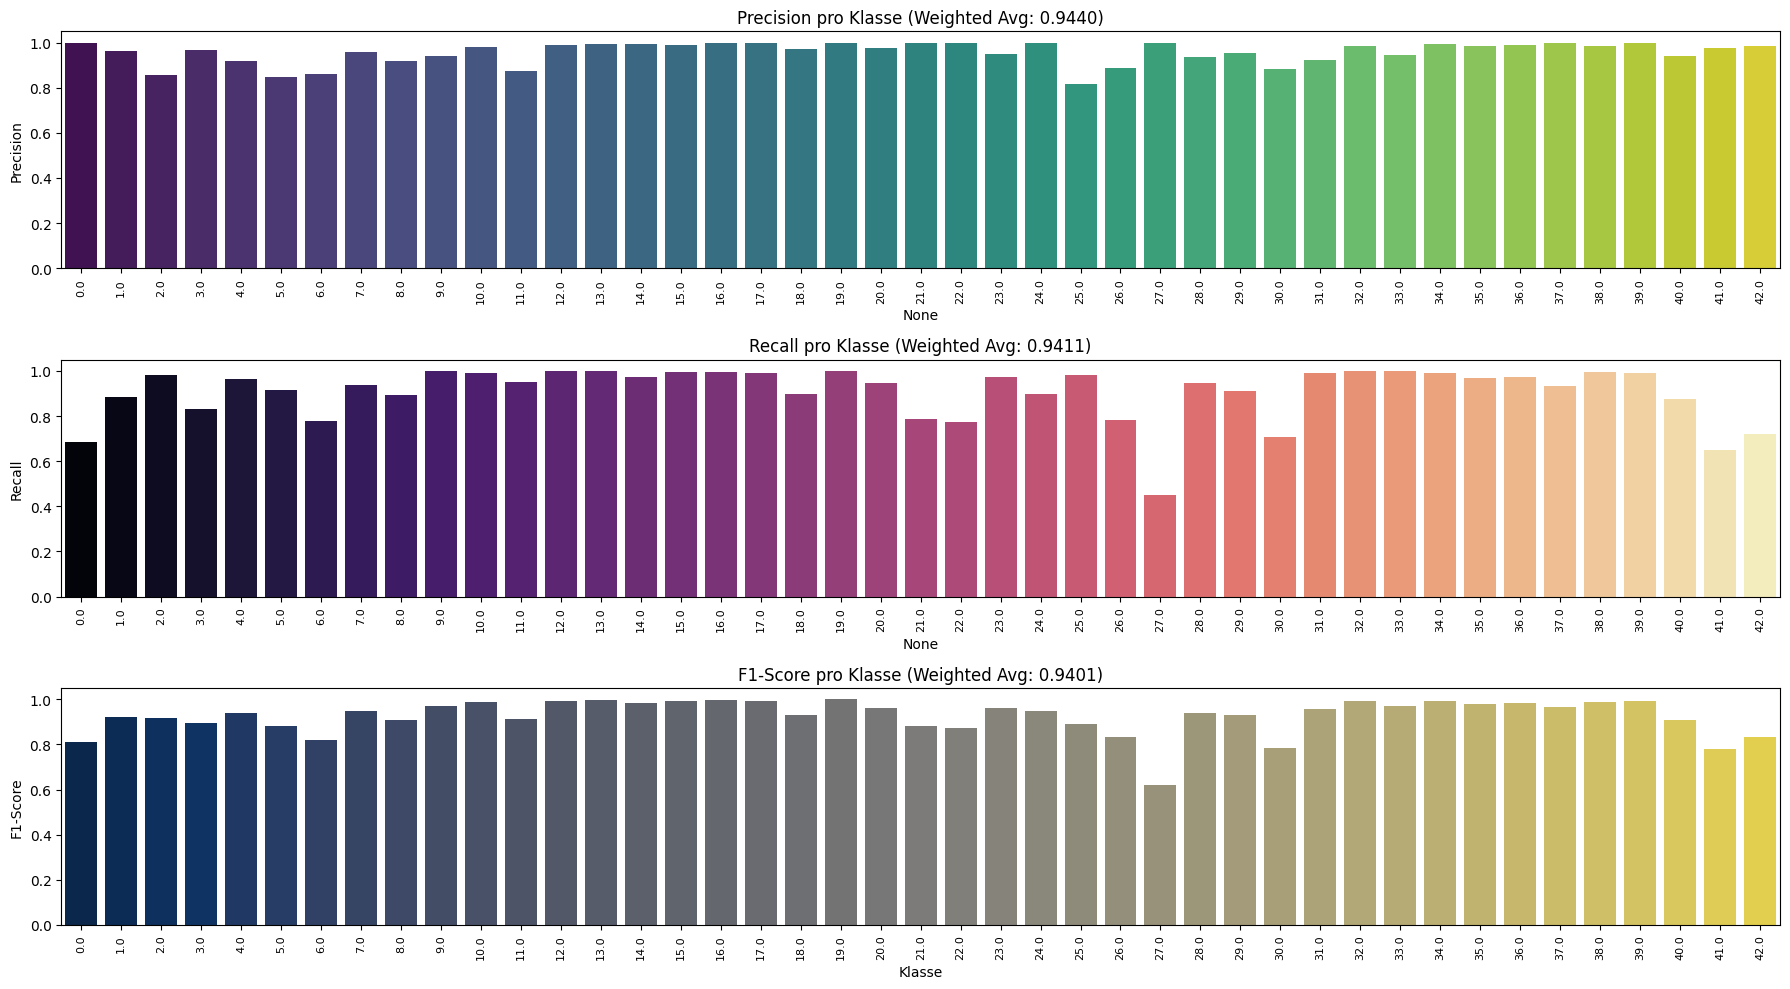

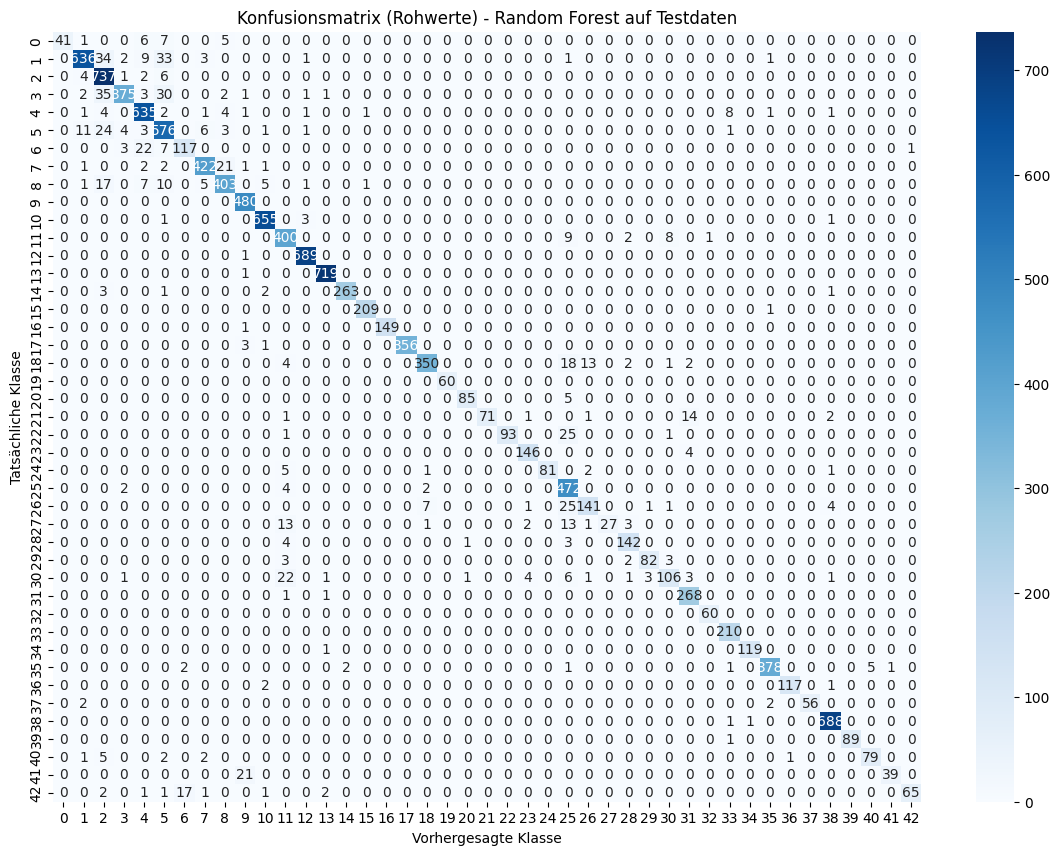

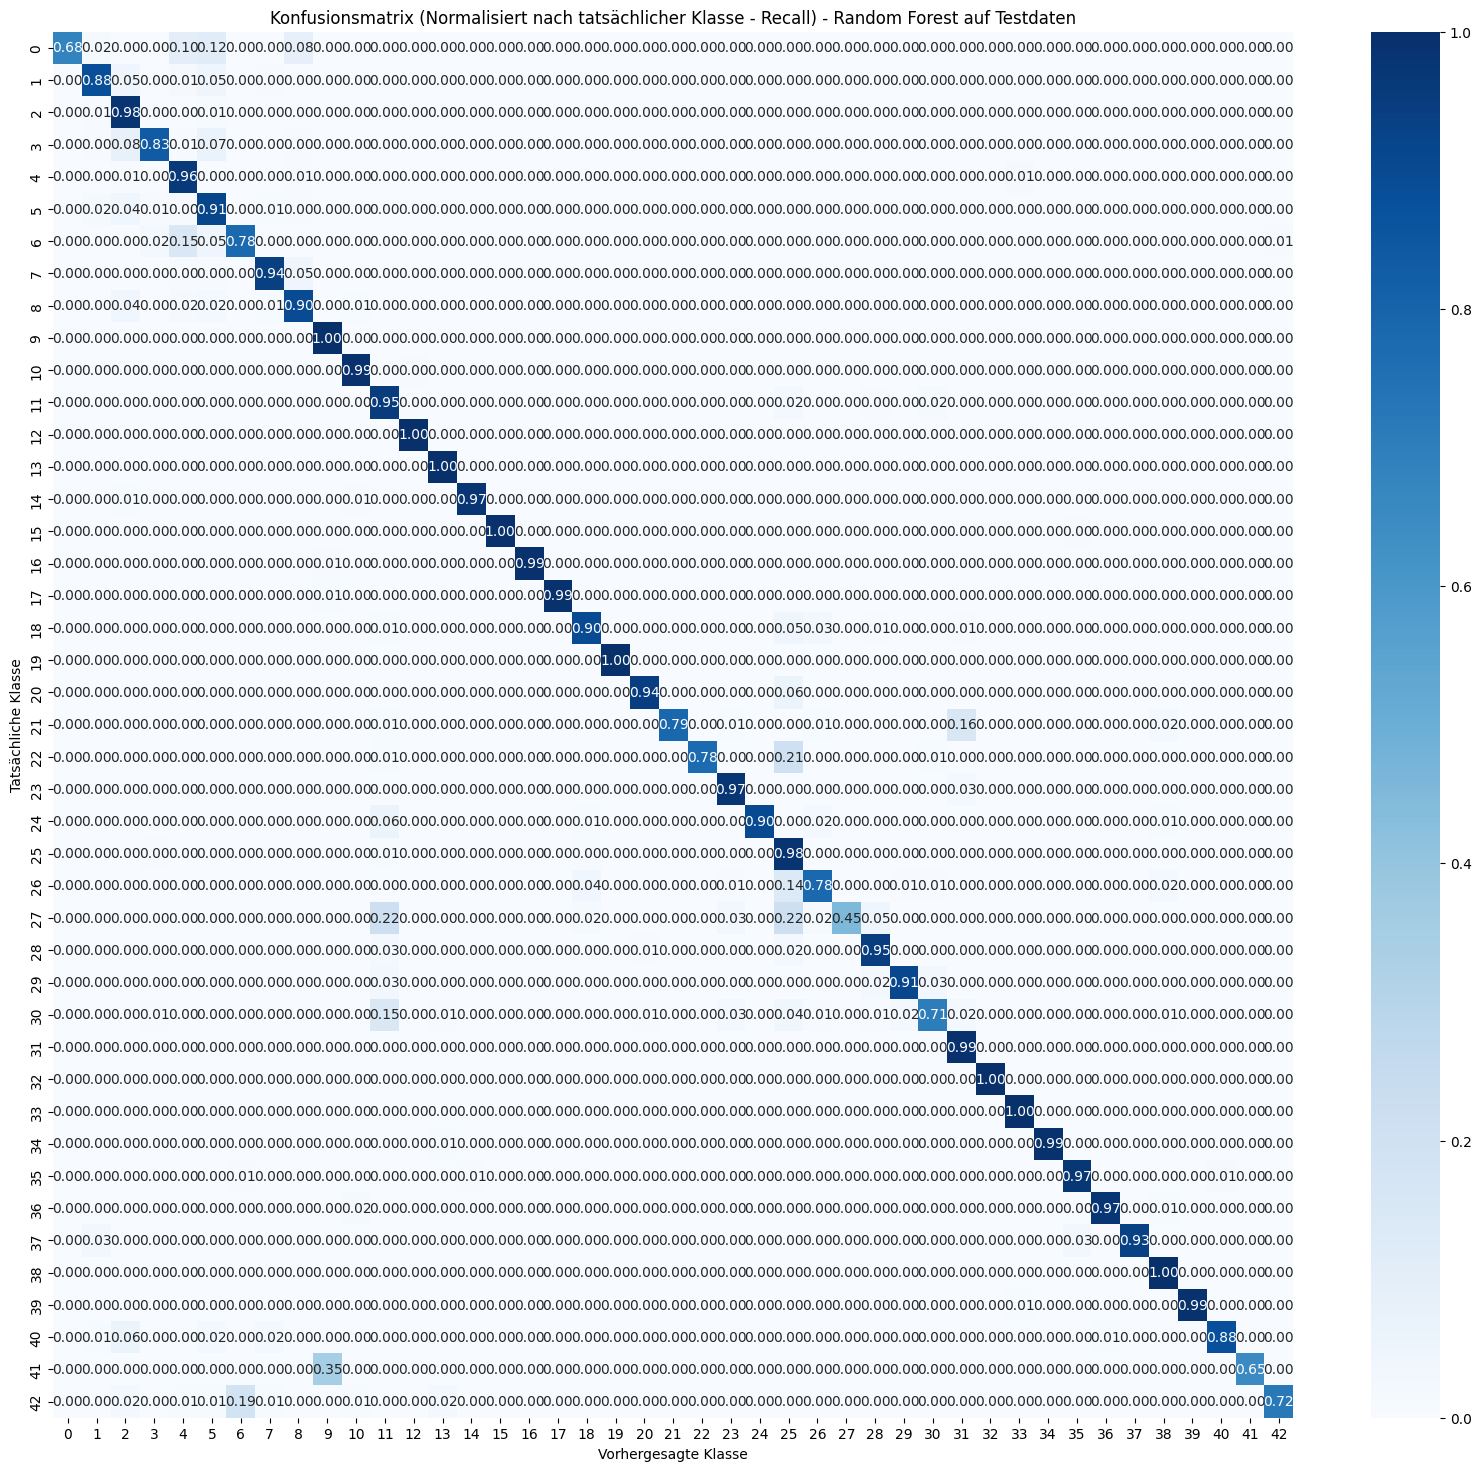

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


y_true_for_viz = y_test_rf        
y_pred_for_viz = y_test_pred_rf  


num_classes = 43

report_dict = classification_report(y_true_for_viz, y_pred_for_viz, output_dict=True, zero_division=0)

df_report = pd.DataFrame(report_dict).transpose()
df_report.index = pd.to_numeric(df_report.index, errors='coerce')
df_report_metrics = df_report[df_report.index.notnull()].sort_index().drop(columns=['support'])


weighted_precision = report_dict['weighted avg']['precision']
weighted_recall = report_dict['weighted avg']['recall']
weighted_f1_score = report_dict['weighted avg']['f1-score']

# --- Balkendiagramme für Precision, Recall und F1-Score ---
plt.figure(figsize=(18, 10)) 

plt.subplot(3, 1, 1)
sns.barplot(x=df_report_metrics.index, y='precision', data=df_report_metrics, palette='viridis')
plt.ylabel('Precision')
plt.title(f'Precision pro Klasse (Weighted Avg: {weighted_precision:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)

plt.subplot(3, 1, 2)
sns.barplot(x=df_report_metrics.index, y='recall', data=df_report_metrics, palette='magma')
plt.ylabel('Recall')
plt.title(f'Recall pro Klasse (Weighted Avg: {weighted_recall:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)

plt.subplot(3, 1, 3)
sns.barplot(x=df_report_metrics.index, y='f1-score', data=df_report_metrics, palette='cividis')
plt.ylabel('F1-Score')
plt.title(f'F1-Score pro Klasse (Weighted Avg: {weighted_f1_score:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Klasse')

plt.tight_layout()
plt.show()

# --- Heatmap der Konfusionsmatrix ---


cm = confusion_matrix(y_true_for_viz, y_pred_for_viz)

plt.figure(figsize=(14, 10)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
plt.title('Konfusionsmatrix (Rohwerte) - Random Forest auf Testdaten')
plt.show()

# Normalisierte Konfusionsmatrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
plt.title('Konfusionsmatrix (Normalisiert nach tatsächlicher Klasse - Recall) - Random Forest auf Testdaten')
plt.show()